In [1]:
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from scipy import sparse
import math

%matplotlib inline

In [2]:
NOTEBOOK_DIR = os.getcwd()
BASE_DIR = os.path.dirname(NOTEBOOK_DIR)
DATA_DIR = os.path.join(BASE_DIR, "data/")

ORDERS = os.path.join(DATA_DIR, "orders.csv")
REVIEWS = os.path.join(DATA_DIR, "reviews.csv")
SIZE_MAPPINGS = os.path.join(DATA_DIR, "size_mapping.csv")
STYLE_ATTR = os.path.join(DATA_DIR, "style_attributes.csv")
USER_ATTR = os.path.join(DATA_DIR, "user_attributes.csv")

DATE_FRMT = "%Y-%m-%d"

#Read in data
orders = pd.read_csv(ORDERS)
reviews = pd.read_csv(REVIEWS)
#size_mappings = pd.read_csv(SIZE_MAPPINGS)
#style_attr = pd.read_csv(STYLE_ATTR)
user_attr = pd.read_csv(USER_ATTR)


In [3]:
def to_dates(df, cols):
    _df = df.copy()
    for col in cols:
        _df[col] = pd.to_datetime(df[col], format=DATE_FRMT)
    return _df

# Orders

 - 1231230 total records, only 1228395 are unique order_ids (~3000 duplicates)
 - 35000 unique user_ids (top has ~ 300 orders)
 - ordered_date between 2017-01-01 and 2018-03-31
 - rental begins between 2017-01-04 and 2018-07-14 (about 1.5 years of data)
 - 4000 unique styles, top 1551
 - 24167 unique skus top 556
 - no missing values
 
 # Questions
 - Why duplicate order_ids?  Are they full-row duplicates (Yes)
 - distribution of user order frequency, how many repeat interactions
 - Last date for ordered_date id 2018-03-31, last date for rental begins is 2018-07-14 (does this imply 3.5 month lag?)
 - does days_rented correlate to satisfaction / fit
 
 ## Collobartive Filtering 
 


In [4]:
orders = to_dates(orders, ['ordered_date', 'rental_begin_date'])
orders.drop_duplicates(inplace=True)
orders.describe(include='all')


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
count,1228395,1228395,1228395,1228395,1228395,1228395,1.228395e+06
unique,1228395,35000,433,378,4000,24167,NaN
top,f79f78cc-b586-30bf-9056-b6a7bce1c76f,a44957e3-180b-3fe0-a2e6-ef83b2cc17c5,2017-10-17 00:00:00,2017-12-20 00:00:00,SAL28,KS95_ONESIZE,NaN
freq,1,307,9436,12296,1549,556,NaN
first,NaN,NaN,2017-01-01 00:00:00,2017-01-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,2018-03-31 00:00:00,2018-07-14 00:00:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.242047e+01
std,NaN,NaN,NaN,NaN,NaN,NaN,2.997819e+01
min,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.000000e+00


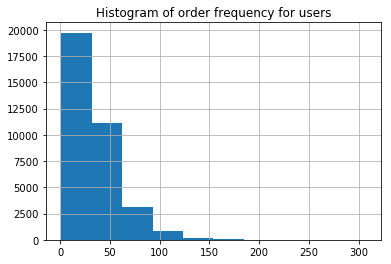

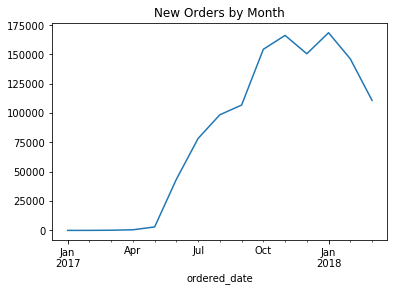

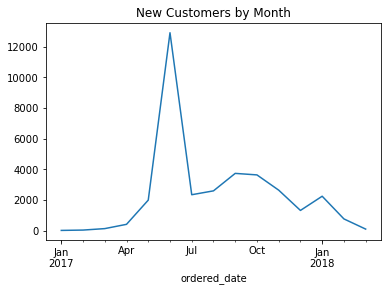

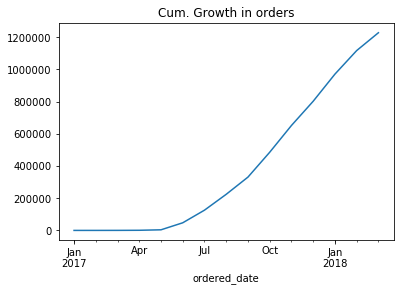

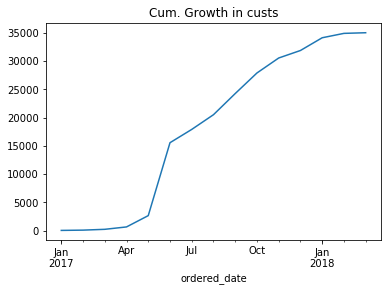

In [5]:
def make_orders_plots(df):
    _df = df.copy()
    
    plt.figure()
    ax = plt.gca()
    _df[['user_id']].apply(pd.value_counts).hist(ax=ax)
    ax.set_title("Histogram of order frequency for users")

    
    _df = _df.set_index("ordered_date").sort_index()
    _df['order_cnt'] = 1
    _df['cust_cnt'] = ~_df['user_id'].duplicated()
    _df['order_cum'] = _df['order_cnt'].cumsum()
    _df['cust_cum'] = _df['cust_cnt'].cumsum()
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Orders by Month")

    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cnt.resample('M', convention='start').sum().plot(ax=ax)
    ax.set_title("New Customers by Month")
    
    plt.figure()
    ax = plt.subplot()
    _df.order_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in orders")
    
    plt.figure()
    ax = plt.subplot()
    _df.cust_cum.resample('M', convention='start').max().plot(ax=ax)
    ax.set_title("Cum. Growth in custs")

make_orders_plots(orders)

In [6]:
from pandas.api.types import CategoricalDtype
reviews.drop_duplicates(inplace=True)
reviews['did_you_wear_it'] = reviews['did_you_wear_it'].astype('category')

like_it_cat_type = CategoricalDtype(categories=['just_okay', 'liked_it', 'loved_it'], ordered=True)
reviews['how_did_you_like_it'] = reviews['how_did_you_like_it'].astype(like_it_cat_type)

reviews['didnt_fit'] = reviews['didnt_fit'].astype('category')
reviews['size_overall'] = reviews['size_overall'].astype('category')
reviews['size_chest'] = reviews['size_chest'].astype('category')
reviews['size_waist'] = reviews['size_waist'].astype('category')
reviews['size_waist.1'] = reviews['size_waist.1'].astype('category')
reviews['length'] = reviews['length'].astype('category')
reviews['not_flattering'] = reviews['not_flattering'].astype('category')
reviews['not_my_style'] = reviews['not_my_style'].astype('category')
reviews['other_issue'] = reviews['other_issue'].astype('category')

In [7]:
#reviews = to_dates(reviews, ['reviewed_date'])
reviews.describe(include='all')
#reviews.size_overall.value_counts()

,order_id,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
count,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395,1228395
unique,1228395,287,2,3,2,4,4,4,4,4,4,2,2,2
top,f79f78cc-b586-30bf-9056-b6a7bce1c76f,2018-03-06,1,loved_it,0,not_asked,not_asked,not_asked,not_asked,not_asked,not_asked,0,0,0
freq,1,9536,832228,490571,1092882,1092882,1092882,1092882,1092882,1092882,1092882,1103353,1175706,1116430


In [45]:
def prepare_data(orders_df, reviews_df):
    
    _orders_df = orders_df.copy()
    _reviews_df = reviews_df.copy()
    _orders_df.set_index("order_id", inplace=True)
    joined = reviews_df.join(_orders_df, how='left', on="order_id")
    joined = joined[['user_id','style','didnt_fit']]
    joined['didnt_fit'] = joined['didnt_fit'].astype(int)
    joined.loc[joined['didnt_fit'] == 0, 'didnt_fit'] = 10
    return joined.groupby(['user_id','style'])['didnt_fit'].mean().unstack()

def data2sparse(df, training_prop, testing_prop):
    (x_inds, y_inds) = np.nonzero(~np.isnan(df.values))
    n = len(x_inds)
    train_inds = set(np.random.choice(n, int(training_prop*n), replace=False))
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    for i in range(n):
        if i in train_inds:
            train_x.append(x_inds[i])
            train_y.append(y_inds[i])
        else:
            test_x.append(x_inds[i])
            test_y.append(y_inds[i])
            
    train = [train_x, train_y]
    test = [test_x, test_y]
    train_sparse = sparse.dok_matrix(sparse.coo_matrix((df.values[train], train), shape = df.shape))
    test_sparse = sparse.dok_matrix(sparse.coo_matrix((df.values[test], test), shape = df.shape))
    return (train_sparse, test_sparse)
    
g = prepare_data(orders, reviews)
(train, testing) = data2sparse(g, .8, .2)

In [29]:
print(train.shape)
print(test.shape)
print(train.nnz)
print(test.nnz)


(35000, 4000)
(35000, 4000)
930554
232639
871, 0
5089, 0
6209, 0
6270, 0
7227, 0
8797, 0
9776, 0
10171, 0
10386, 0
10691, 0
12083, 0
12263, 0
15285, 0
16152, 0
16604, 0
17368, 0
19322, 0
19828, 0
23729, 0
24043, 0
24190, 0
25045, 0
25439, 0
26092, 0
28414, 0
30453, 0
30530, 0
32008, 0
33326, 0
33707, 0
33738, 0
34824, 0
4, 1
1003, 1
1238, 1
1968, 1
2131, 1
2265, 1
3249, 1
3307, 1
3359, 1
4689, 1
4842, 1
5243, 1
5267, 1
6239, 1
6887, 1
7041, 1
7095, 1
7350, 1
8142, 1
9328, 1
9537, 1
9720, 1
10065, 1
10205, 1
10336, 1
10987, 1
11861, 1
11928, 1
12121, 1
12902, 1
13018, 1
13459, 1
14545, 1
16118, 1
16244, 1
17217, 1
17219, 1
17273, 1
17482, 1
17825, 1
17985, 1
18290, 1
18595, 1
21392, 1
21818, 1
22074, 1
22919, 1
23286, 1
23334, 1
25360, 1
25892, 1
26948, 1
26989, 1
27015, 1
27631, 1
27788, 1
29217, 1
29280, 1
29378, 1
30653, 1
31212, 1
32632, 1
32635, 1
32728, 1
33466, 1
34587, 1
34657, 1
34795, 1
82, 2
347, 2
362, 2
540, 2
1325, 2
1362, 2
1674, 2
1907, 2
3593, 2
3978, 2
4037, 2
4494, 2


31193, 33
31749, 33
32097, 33
32162, 33
32239, 33
32383, 33
32709, 33
32958, 33
33183, 33
33560, 33
33613, 33
33951, 33
34340, 33
669, 34
786, 34
1244, 34
1455, 34
1859, 34
2238, 34
2615, 34
4556, 34
5511, 34
6362, 34
6499, 34
7060, 34
7914, 34
7918, 34
8391, 34
8563, 34
12474, 34
12659, 34
12971, 34
13087, 34
15034, 34
15225, 34
15422, 34
15446, 34
16109, 34
16654, 34
18620, 34
21234, 34
22300, 34
23532, 34
24206, 34
24762, 34
25168, 34
25232, 34
25903, 34
27635, 34
29897, 34
29991, 34
30737, 34
30881, 34
31693, 34
33459, 34
33837, 34
1257, 35
1324, 35
2301, 35
4350, 35
5040, 35
5176, 35
5423, 35
6812, 35
7762, 35
8900, 35
9933, 35
10265, 35
13457, 35
13642, 35
14115, 35
15056, 35
17232, 35
18634, 35
19217, 35
19618, 35
19772, 35
21021, 35
22270, 35
23481, 35
26426, 35
26631, 35
26645, 35
27016, 35
27462, 35
27530, 35
27591, 35
29749, 35
31106, 35
31994, 35
32321, 35
32438, 35
32850, 35
34321, 35
134, 36
281, 36
391, 36
507, 36
836, 36
891, 36
914, 36
939, 36
1525, 36
1661, 36
1722, 3

23155, 76
23513, 76
23716, 76
24738, 76
24813, 76
25632, 76
26079, 76
26396, 76
26747, 76
27025, 76
27435, 76
27717, 76
27801, 76
27910, 76
27928, 76
27984, 76
28289, 76
28326, 76
28472, 76
28657, 76
29887, 76
30139, 76
30534, 76
30964, 76
31277, 76
31315, 76
31494, 76
31733, 76
32077, 76
32271, 76
32323, 76
32454, 76
32628, 76
32801, 76
32874, 76
33098, 76
33534, 76
33901, 76
34248, 76
34945, 76
385, 77
607, 77
1125, 77
1911, 77
2424, 77
3108, 77
3547, 77
3891, 77
3935, 77
4007, 77
4730, 77
5020, 77
6434, 77
6531, 77
6905, 77
7860, 77
7886, 77
8348, 77
8410, 77
8678, 77
8703, 77
9361, 77
12041, 77
12290, 77
12591, 77
12682, 77
12745, 77
12955, 77
13065, 77
13278, 77
13279, 77
14891, 77
15757, 77
16622, 77
17004, 77
17712, 77
17771, 77
18045, 77
18086, 77
18180, 77
18918, 77
19754, 77
20104, 77
20304, 77
20388, 77
22003, 77
22703, 77
22725, 77
24458, 77
26682, 77
26772, 77
26961, 77
27840, 77
27919, 77
28010, 77
28368, 77
28677, 77
29053, 77
29306, 77
29753, 77
29840, 77
30200, 77
3088

8209, 130
10287, 130
10761, 130
11160, 130
11522, 130
11707, 130
11919, 130
12021, 130
12145, 130
12184, 130
12494, 130
12940, 130
12982, 130
13119, 130
13574, 130
13789, 130
14083, 130
14094, 130
14168, 130
14276, 130
14480, 130
14627, 130
15695, 130
17786, 130
18688, 130
18859, 130
19218, 130
19620, 130
20518, 130
20845, 130
20897, 130
20977, 130
22921, 130
23514, 130
24060, 130
24355, 130
24524, 130
24669, 130
25268, 130
25371, 130
25763, 130
25867, 130
27229, 130
28486, 130
28956, 130
30065, 130
30299, 130
30612, 130
30704, 130
30730, 130
30860, 130
30946, 130
31191, 130
31521, 130
31913, 130
32053, 130
32054, 130
32626, 130
32842, 130
33070, 130
33358, 130
33872, 130
33988, 130
34135, 130
34196, 130
34261, 130
34277, 130
34368, 130
34831, 130
2121, 131
3694, 131
8267, 131
10516, 131
10825, 131
12459, 131
13268, 131
16359, 131
16894, 131
18030, 131
19746, 131
20139, 131
21430, 131
22486, 131
24545, 131
25061, 131
25763, 131
25957, 131
25986, 131
26583, 131
26618, 131
27478, 131
303

33655, 190
34210, 190
475, 191
717, 191
2953, 191
2977, 191
3029, 191
4172, 191
4962, 191
5306, 191
5733, 191
6926, 191
7015, 191
7970, 191
8028, 191
8583, 191
8807, 191
9141, 191
9226, 191
11562, 191
11974, 191
12146, 191
12692, 191
12753, 191
12757, 191
12960, 191
14190, 191
14915, 191
16605, 191
16996, 191
19159, 191
20010, 191
20065, 191
20622, 191
21202, 191
21458, 191
21667, 191
21701, 191
22158, 191
22509, 191
22621, 191
23916, 191
24105, 191
24858, 191
24864, 191
26498, 191
28841, 191
28898, 191
28992, 191
30641, 191
31597, 191
31733, 191
32191, 191
33086, 191
33117, 191
33506, 191
33601, 191
34609, 191
34934, 191
34937, 191
964, 192
1260, 192
1725, 192
2520, 192
3986, 192
4668, 192
4730, 192
6552, 192
7104, 192
7321, 192
7604, 192
8056, 192
8534, 192
8817, 192
8842, 192
9209, 192
9307, 192
11421, 192
11496, 192
11499, 192
12918, 192
13430, 192
13680, 192
14174, 192
14774, 192
16167, 192
16712, 192
17383, 192
18265, 192
18855, 192
19381, 192
20331, 192
20445, 192
20960, 192
212

28416, 239
29363, 239
30285, 239
31204, 239
31346, 239
31365, 239
31374, 239
31652, 239
31672, 239
31801, 239
31922, 239
32469, 239
33320, 239
33744, 239
33810, 239
34972, 239
223, 240
257, 240
1680, 240
1956, 240
2050, 240
2252, 240
2588, 240
2871, 240
3218, 240
3528, 240
4957, 240
5431, 240
5443, 240
5954, 240
7290, 240
8227, 240
8249, 240
8263, 240
10032, 240
10420, 240
10960, 240
11019, 240
12132, 240
12245, 240
12358, 240
12567, 240
13203, 240
14111, 240
14193, 240
14352, 240
14500, 240
14520, 240
15627, 240
15944, 240
16105, 240
16629, 240
17115, 240
17422, 240
17428, 240
17507, 240
19234, 240
19245, 240
19313, 240
20822, 240
21102, 240
21655, 240
21896, 240
22032, 240
22724, 240
23374, 240
23952, 240
24120, 240
24196, 240
24335, 240
25154, 240
25570, 240
25900, 240
25978, 240
27519, 240
28585, 240
28664, 240
29088, 240
30003, 240
30151, 240
31651, 240
31794, 240
31989, 240
32622, 240
34075, 240
34644, 240
291, 241
642, 241
662, 241
906, 241
970, 241
1300, 241
1389, 241
1548, 241

14062, 297
16710, 297
17920, 297
18793, 297
18875, 297
19377, 297
20960, 297
21227, 297
21416, 297
22805, 297
23105, 297
23417, 297
23898, 297
24467, 297
25276, 297
26616, 297
27881, 297
28148, 297
30104, 297
31323, 297
32596, 297
32673, 297
33309, 297
33315, 297
33720, 297
2916, 298
4066, 298
4149, 298
4172, 298
4228, 298
5010, 298
5786, 298
6851, 298
7245, 298
8828, 298
11069, 298
13304, 298
13348, 298
14371, 298
14913, 298
15635, 298
16461, 298
20555, 298
20560, 298
20565, 298
21238, 298
23209, 298
24834, 298
26350, 298
26625, 298
27490, 298
30092, 298
33257, 298
341, 299
710, 299
961, 299
1086, 299
1367, 299
1469, 299
1640, 299
2131, 299
2849, 299
3182, 299
3988, 299
3989, 299
3996, 299
5220, 299
5638, 299
5688, 299
5969, 299
5982, 299
6851, 299
7299, 299
7513, 299
7780, 299
7900, 299
7912, 299
8007, 299
8149, 299
9124, 299
9506, 299
9945, 299
9974, 299
10374, 299
11075, 299
11820, 299
12005, 299
12623, 299
12827, 299
13156, 299
13407, 299
13503, 299
13585, 299
13611, 299
13697, 29

21800, 347
22108, 347
22186, 347
23268, 347
23286, 347
23918, 347
24212, 347
24610, 347
25021, 347
25260, 347
25902, 347
26129, 347
26243, 347
26338, 347
26617, 347
26673, 347
27013, 347
27422, 347
27568, 347
28305, 347
28345, 347
28491, 347
29726, 347
29827, 347
29990, 347
30295, 347
31806, 347
31818, 347
31861, 347
31964, 347
32850, 347
33000, 347
33537, 347
34772, 347
34925, 347
954, 348
1417, 348
1620, 348
5307, 348
6254, 348
6971, 348
7786, 348
8460, 348
8929, 348
10205, 348
11245, 348
11536, 348
12247, 348
14370, 348
14383, 348
14976, 348
15929, 348
17458, 348
19557, 348
20527, 348
21903, 348
22248, 348
23004, 348
23785, 348
23866, 348
25094, 348
26177, 348
27338, 348
28022, 348
28069, 348
28297, 348
29152, 348
29835, 348
29952, 348
30355, 348
30945, 348
31156, 348
32352, 348
32659, 348
32768, 348
33271, 348
34266, 348
1916, 349
2136, 349
5007, 349
9563, 349
9985, 349
10578, 349
11312, 349
14558, 349
15272, 349
17584, 349
19896, 349
21029, 349
21032, 349
22148, 349
23638, 349
237

28568, 417
29590, 417
29673, 417
29991, 417
32634, 417
33055, 417
21, 418
1002, 418
1836, 418
2603, 418
2633, 418
5341, 418
6427, 418
8305, 418
8918, 418
9160, 418
10046, 418
10279, 418
10439, 418
11790, 418
12284, 418
12537, 418
12912, 418
13548, 418
13768, 418
15624, 418
16523, 418
17053, 418
17665, 418
18646, 418
20712, 418
22998, 418
23168, 418
23794, 418
25278, 418
27878, 418
28047, 418
28483, 418
29518, 418
29557, 418
29621, 418
29707, 418
30142, 418
30308, 418
31041, 418
31621, 418
34761, 418
34859, 418
447, 419
3498, 419
4884, 419
6439, 419
6507, 419
8958, 419
9994, 419
10112, 419
10268, 419
13428, 419
14744, 419
17494, 419
20032, 419
20098, 419
20768, 419
21855, 419
22330, 419
25567, 419
28047, 419
28192, 419
28500, 419
30259, 419
30499, 419
31880, 419
34449, 419
34770, 419
1582, 420
1865, 420
6145, 420
9490, 420
10273, 420
10677, 420
11669, 420
12750, 420
13695, 420
15081, 420
17631, 420
18879, 420
20181, 420
20426, 420
21053, 420
21239, 420
21461, 420
24200, 420
24771, 420
2

32268, 475
33125, 475
33402, 475
33414, 475
494, 476
1096, 476
1839, 476
1896, 476
3176, 476
3641, 476
4224, 476
4745, 476
7960, 476
8366, 476
9354, 476
10162, 476
10484, 476
12174, 476
14581, 476
15636, 476
16690, 476
16822, 476
17248, 476
18671, 476
18938, 476
19266, 476
19411, 476
20269, 476
20992, 476
22636, 476
23075, 476
24191, 476
24294, 476
24304, 476
24549, 476
25431, 476
26907, 476
28459, 476
29595, 476
29846, 476
30193, 476
31451, 476
33200, 476
33306, 476
33660, 476
33684, 476
158, 477
1070, 477
1138, 477
1499, 477
2039, 477
2365, 477
2755, 477
3311, 477
3379, 477
3979, 477
4810, 477
5074, 477
5115, 477
5148, 477
5971, 477
8041, 477
9725, 477
10014, 477
11226, 477
11642, 477
11710, 477
12246, 477
13134, 477
13602, 477
14389, 477
14976, 477
15977, 477
16514, 477
16702, 477
16822, 477
17580, 477
17734, 477
17751, 477
18066, 477
18234, 477
18894, 477
19474, 477
20340, 477
20343, 477
21022, 477
22273, 477
22670, 477
22849, 477
23165, 477
23196, 477
23222, 477
23261, 477
23361, 

983, 522
1058, 522
6051, 522
7182, 522
7289, 522
8108, 522
8201, 522
8225, 522
8953, 522
9348, 522
11234, 522
12290, 522
12738, 522
13787, 522
14731, 522
14847, 522
15835, 522
16626, 522
17178, 522
17743, 522
19268, 522
20430, 522
20573, 522
20737, 522
20945, 522
21817, 522
22703, 522
23336, 522
24288, 522
26341, 522
26686, 522
28751, 522
29519, 522
32159, 522
33810, 522
33835, 522
34337, 522
34881, 522
1125, 523
2574, 523
2849, 523
4009, 523
5824, 523
7995, 523
8436, 523
9435, 523
10374, 523
10593, 523
10731, 523
11660, 523
15386, 523
17729, 523
19646, 523
20300, 523
21838, 523
22463, 523
23783, 523
23900, 523
24813, 523
25910, 523
27146, 523
27543, 523
30029, 523
30350, 523
30389, 523
30459, 523
33115, 523
570, 524
882, 524
1295, 524
1467, 524
2472, 524
4257, 524
4796, 524
4971, 524
5196, 524
5359, 524
6639, 524
6675, 524
7272, 524
7511, 524
7978, 524
8328, 524
8880, 524
9162, 524
9443, 524
10253, 524
11014, 524
11307, 524
11849, 524
13444, 524
13655, 524
13671, 524
13899, 524
14325,

29247, 572
29439, 572
29543, 572
29877, 572
30467, 572
32011, 572
32571, 572
32716, 572
33534, 572
34228, 572
34243, 572
34591, 572
34700, 572
34773, 572
34992, 572
16, 573
836, 573
1706, 573
2698, 573
3275, 573
3767, 573
4816, 573
5398, 573
6101, 573
6447, 573
6613, 573
7060, 573
7366, 573
7386, 573
8312, 573
8571, 573
9265, 573
10759, 573
10903, 573
11005, 573
11271, 573
11650, 573
11752, 573
12011, 573
12019, 573
12225, 573
12621, 573
12883, 573
13123, 573
14065, 573
14295, 573
14319, 573
14796, 573
15071, 573
15394, 573
15900, 573
17179, 573
17525, 573
19490, 573
20294, 573
20520, 573
21606, 573
21970, 573
22472, 573
23244, 573
23424, 573
24650, 573
25364, 573
27221, 573
28288, 573
28355, 573
28647, 573
28758, 573
28918, 573
29204, 573
29906, 573
29987, 573
30201, 573
30252, 573
32471, 573
32872, 573
33008, 573
33655, 573
34027, 573
34149, 573
34443, 573
34558, 573
6253, 574
6542, 574
10040, 574
10400, 574
11565, 574
13866, 574
15055, 574
15512, 574
17448, 574
18273, 574
18478, 574

16098, 629
16150, 629
17073, 629
17872, 629
17895, 629
18084, 629
18097, 629
18283, 629
18519, 629
18924, 629
19583, 629
19970, 629
20028, 629
20130, 629
21000, 629
21461, 629
22298, 629
22439, 629
22457, 629
22776, 629
23572, 629
23738, 629
23914, 629
24545, 629
25257, 629
26299, 629
27324, 629
27434, 629
27632, 629
28049, 629
28308, 629
28557, 629
29448, 629
29904, 629
29980, 629
30492, 629
31307, 629
31365, 629
32003, 629
34376, 629
13, 630
398, 630
2805, 630
2892, 630
3705, 630
6836, 630
7308, 630
7602, 630
8935, 630
12427, 630
12981, 630
13058, 630
13342, 630
13463, 630
14051, 630
19332, 630
19395, 630
19495, 630
20150, 630
20426, 630
21343, 630
22773, 630
22793, 630
26008, 630
26568, 630
27343, 630
29216, 630
31823, 630
968, 631
1000, 631
1819, 631
3832, 631
4188, 631
7057, 631
8378, 631
8550, 631
10352, 631
13428, 631
15214, 631
18304, 631
21090, 631
22093, 631
23147, 631
23289, 631
24928, 631
25799, 631
27055, 631
27507, 631
27900, 631
30936, 631
31005, 631
31628, 631
4330, 632

9918, 693
13503, 693
13736, 693
14951, 693
15045, 693
15409, 693
16044, 693
16362, 693
16369, 693
16547, 693
18029, 693
19153, 693
19616, 693
20378, 693
20581, 693
20775, 693
20974, 693
21192, 693
21271, 693
23790, 693
24211, 693
24371, 693
24385, 693
25010, 693
25117, 693
25353, 693
25855, 693
26037, 693
26283, 693
26294, 693
27914, 693
28571, 693
30691, 693
31601, 693
31684, 693
32862, 693
32867, 693
33662, 693
34156, 693
34858, 693
1964, 694
3101, 694
3157, 694
3714, 694
4212, 694
4339, 694
4555, 694
5291, 694
5780, 694
5792, 694
6433, 694
6720, 694
7193, 694
8754, 694
8920, 694
9640, 694
10294, 694
10477, 694
10736, 694
11000, 694
15079, 694
15350, 694
15525, 694
15691, 694
16604, 694
16856, 694
18385, 694
18431, 694
18743, 694
18914, 694
20228, 694
20270, 694
21097, 694
21555, 694
21687, 694
22035, 694
22224, 694
23732, 694
24480, 694
24534, 694
25078, 694
25134, 694
25468, 694
25583, 694
26815, 694
27296, 694
27430, 694
27524, 694
27610, 694
27656, 694
27977, 694
29562, 694
29902

11721, 743
12227, 743
12799, 743
13132, 743
13162, 743
13176, 743
13188, 743
13980, 743
14059, 743
14129, 743
14434, 743
14897, 743
14960, 743
15375, 743
15745, 743
15773, 743
15822, 743
16368, 743
16381, 743
16433, 743
16708, 743
17105, 743
17834, 743
17990, 743
18454, 743
18474, 743
18486, 743
18662, 743
18764, 743
18849, 743
19083, 743
19092, 743
19101, 743
19194, 743
19387, 743
19808, 743
20156, 743
20245, 743
20436, 743
20553, 743
20599, 743
20661, 743
21092, 743
21218, 743
21329, 743
21406, 743
23278, 743
23869, 743
24223, 743
25598, 743
26283, 743
26314, 743
26329, 743
26520, 743
26753, 743
26886, 743
27018, 743
27222, 743
27419, 743
27450, 743
28383, 743
28583, 743
28590, 743
28681, 743
28732, 743
29229, 743
29235, 743
29285, 743
29659, 743
29746, 743
29871, 743
29890, 743
29933, 743
30001, 743
30021, 743
30083, 743
30303, 743
30322, 743
30584, 743
30612, 743
30631, 743
30758, 743
31140, 743
32019, 743
32093, 743
32113, 743
32249, 743
32438, 743
32728, 743
32884, 743
32921, 743

8219, 771
10073, 771
11572, 771
12574, 771
13180, 771
13524, 771
14002, 771
15585, 771
16073, 771
16421, 771
16621, 771
16837, 771
17066, 771
17467, 771
17799, 771
19141, 771
19376, 771
20595, 771
20728, 771
21023, 771
21924, 771
21950, 771
22590, 771
22700, 771
24039, 771
24184, 771
25008, 771
25206, 771
26748, 771
26930, 771
27867, 771
28443, 771
29394, 771
30360, 771
30997, 771
32249, 771
32801, 771
32850, 771
33046, 771
33348, 771
4, 772
890, 772
1206, 772
1950, 772
1992, 772
2344, 772
2399, 772
2787, 772
2792, 772
3076, 772
3547, 772
3765, 772
3915, 772
3963, 772
4154, 772
4309, 772
4365, 772
4405, 772
4894, 772
5876, 772
5948, 772
6078, 772
6802, 772
7018, 772
7677, 772
7894, 772
8108, 772
8859, 772
8876, 772
8945, 772
8958, 772
9173, 772
9625, 772
9685, 772
10226, 772
10599, 772
10758, 772
10940, 772
11126, 772
11288, 772
11507, 772
11687, 772
11810, 772
11934, 772
12411, 772
12517, 772
13063, 772
13920, 772
15169, 772
15261, 772
15585, 772
15614, 772
15834, 772
15907, 772
16377

28126, 806
28503, 806
28705, 806
29391, 806
29594, 806
29689, 806
29717, 806
30044, 806
30158, 806
30462, 806
30564, 806
31020, 806
31620, 806
32123, 806
32127, 806
32423, 806
32727, 806
32968, 806
33237, 806
33259, 806
33305, 806
33632, 806
34101, 806
34376, 806
34958, 806
34991, 806
19, 807
63, 807
291, 807
344, 807
578, 807
599, 807
605, 807
876, 807
1179, 807
1484, 807
2236, 807
2733, 807
2873, 807
3110, 807
3317, 807
3320, 807
3347, 807
3368, 807
3745, 807
3798, 807
4060, 807
4316, 807
5201, 807
6031, 807
6155, 807
6776, 807
6846, 807
6958, 807
7285, 807
7417, 807
7458, 807
7547, 807
7564, 807
7871, 807
8060, 807
8260, 807
8280, 807
8339, 807
8995, 807
9006, 807
9265, 807
9626, 807
9688, 807
9839, 807
10467, 807
10600, 807
10675, 807
11716, 807
11898, 807
12069, 807
13812, 807
13855, 807
14582, 807
15331, 807
15633, 807
15705, 807
15976, 807
16262, 807
16472, 807
16534, 807
16711, 807
16742, 807
16800, 807
17057, 807
17115, 807
17222, 807
17589, 807
18940, 807
19159, 807
19490, 80

28000, 842
28647, 842
29259, 842
30505, 842
31534, 842
33237, 842
33455, 842
33781, 842
1825, 843
1929, 843
5699, 843
5743, 843
5763, 843
12759, 843
14451, 843
14701, 843
15046, 843
15413, 843
15968, 843
16703, 843
17018, 843
18431, 843
19754, 843
20001, 843
20312, 843
20965, 843
22033, 843
23091, 843
24136, 843
24153, 843
24946, 843
25841, 843
28062, 843
28403, 843
28967, 843
30175, 843
32832, 843
33138, 843
418, 844
3880, 844
4044, 844
5860, 844
6509, 844
6860, 844
7965, 844
8460, 844
8588, 844
8921, 844
9661, 844
10080, 844
10369, 844
11067, 844
12082, 844
12926, 844
13119, 844
13180, 844
13341, 844
14901, 844
15347, 844
16150, 844
17698, 844
18463, 844
19958, 844
21333, 844
21377, 844
21484, 844
21699, 844
23532, 844
25981, 844
26146, 844
26199, 844
27327, 844
28062, 844
28064, 844
28845, 844
32390, 844
32582, 844
33256, 844
33990, 844
1974, 845
2039, 845
3487, 845
4972, 845
6677, 845
7624, 845
8991, 845
12132, 845
13218, 845
14400, 845
14573, 845
14734, 845
15606, 845
16047, 845
1

4306, 888
7736, 888
7990, 888
8028, 888
10370, 888
10560, 888
10610, 888
12617, 888
13902, 888
13928, 888
14125, 888
15551, 888
15778, 888
15840, 888
16503, 888
16770, 888
17330, 888
19985, 888
20338, 888
22059, 888
22306, 888
22718, 888
24024, 888
25928, 888
26111, 888
26507, 888
27185, 888
28044, 888
28315, 888
28359, 888
28579, 888
29661, 888
30434, 888
30473, 888
30529, 888
30780, 888
31825, 888
32435, 888
32824, 888
33400, 888
34284, 888
34449, 888
34601, 888
66, 889
313, 889
347, 889
655, 889
940, 889
1275, 889
2274, 889
2596, 889
3446, 889
4041, 889
4346, 889
4443, 889
5041, 889
5500, 889
6160, 889
6563, 889
6710, 889
6735, 889
7081, 889
7889, 889
7953, 889
8021, 889
8028, 889
8294, 889
8812, 889
9477, 889
9712, 889
9854, 889
10681, 889
10732, 889
11063, 889
11139, 889
11304, 889
11824, 889
12289, 889
12310, 889
12702, 889
12782, 889
13162, 889
13484, 889
13796, 889
13880, 889
13922, 889
14233, 889
14474, 889
14829, 889
15166, 889
15579, 889
15672, 889
15717, 889
15928, 889
1599

9833, 935
11288, 935
11579, 935
11764, 935
12044, 935
12653, 935
12667, 935
13280, 935
13734, 935
15045, 935
15185, 935
15469, 935
16652, 935
16949, 935
17728, 935
18416, 935
19208, 935
19839, 935
20416, 935
20823, 935
20891, 935
21532, 935
21573, 935
21977, 935
22246, 935
22608, 935
22791, 935
23588, 935
23604, 935
25324, 935
25919, 935
26223, 935
26476, 935
27579, 935
27609, 935
28254, 935
28444, 935
31405, 935
31461, 935
31508, 935
32193, 935
32791, 935
33113, 935
33204, 935
33616, 935
33741, 935
34014, 935
34024, 935
34501, 935
34678, 935
2154, 936
4000, 936
4086, 936
9624, 936
10070, 936
10260, 936
10611, 936
17366, 936
18196, 936
18674, 936
20663, 936
25184, 936
25655, 936
26317, 936
26887, 936
26902, 936
29180, 936
31540, 936
34853, 936
223, 937
915, 937
1427, 937
5204, 937
6463, 937
6728, 937
9697, 937
11078, 937
11381, 937
11494, 937
12303, 937
12344, 937
12867, 937
15118, 937
15300, 937
16819, 937
18237, 937
18723, 937
19383, 937
22929, 937
24336, 937
25021, 937
25896, 937
27

7548, 980
8043, 980
8106, 980
8173, 980
8380, 980
8703, 980
9719, 980
10271, 980
10357, 980
10622, 980
11084, 980
11361, 980
11527, 980
12016, 980
13077, 980
13513, 980
14040, 980
14143, 980
14515, 980
14668, 980
14988, 980
15044, 980
15297, 980
16049, 980
16126, 980
16271, 980
16580, 980
16636, 980
16819, 980
16974, 980
17164, 980
17263, 980
17892, 980
18012, 980
18224, 980
18247, 980
18437, 980
18454, 980
18585, 980
18962, 980
19192, 980
19259, 980
19368, 980
19566, 980
19591, 980
19674, 980
20251, 980
20275, 980
20517, 980
20581, 980
20703, 980
20817, 980
20904, 980
21637, 980
22147, 980
22149, 980
22249, 980
22499, 980
23304, 980
23331, 980
23346, 980
23512, 980
23610, 980
23679, 980
23970, 980
24120, 980
24163, 980
24339, 980
24768, 980
24876, 980
25453, 980
25619, 980
25840, 980
25878, 980
25889, 980
26297, 980
26559, 980
26625, 980
26701, 980
27090, 980
27418, 980
27427, 980
27644, 980
28591, 980
28909, 980
29225, 980
29313, 980
30127, 980
30470, 980
30524, 980
30759, 980
31829,

5604, 1010
5786, 1010
6768, 1010
6993, 1010
7663, 1010
7732, 1010
8122, 1010
8212, 1010
8343, 1010
9468, 1010
9539, 1010
10045, 1010
10068, 1010
10154, 1010
10406, 1010
10681, 1010
11585, 1010
11724, 1010
11786, 1010
12291, 1010
12763, 1010
12766, 1010
12918, 1010
13076, 1010
13131, 1010
13920, 1010
14227, 1010
14582, 1010
14660, 1010
15105, 1010
15855, 1010
15978, 1010
16686, 1010
16742, 1010
18119, 1010
18843, 1010
19136, 1010
19232, 1010
19381, 1010
19418, 1010
19564, 1010
19827, 1010
19855, 1010
19866, 1010
20462, 1010
21072, 1010
21096, 1010
21380, 1010
21842, 1010
21962, 1010
22033, 1010
22500, 1010
22700, 1010
24015, 1010
24038, 1010
24566, 1010
24728, 1010
25064, 1010
25667, 1010
26119, 1010
26827, 1010
26878, 1010
26983, 1010
27178, 1010
29097, 1010
29414, 1010
29447, 1010
29456, 1010
29626, 1010
29672, 1010
29993, 1010
31033, 1010
31258, 1010
31289, 1010
33400, 1010
33591, 1010
33596, 1010
33634, 1010
33654, 1010
34861, 1010
527, 1011
623, 1011
937, 1011
1134, 1011
1677, 1011

12730, 1031
12785, 1031
12806, 1031
13084, 1031
13453, 1031
13979, 1031
14858, 1031
16569, 1031
16596, 1031
16769, 1031
17294, 1031
17969, 1031
18130, 1031
19214, 1031
19538, 1031
19800, 1031
19807, 1031
20357, 1031
20513, 1031
21248, 1031
21792, 1031
21896, 1031
22001, 1031
22129, 1031
24301, 1031
24383, 1031
25285, 1031
26676, 1031
28100, 1031
29197, 1031
29289, 1031
29786, 1031
30272, 1031
30621, 1031
31157, 1031
31406, 1031
31578, 1031
32454, 1031
32525, 1031
32575, 1031
34288, 1031
34760, 1031
34858, 1031
1024, 1032
1079, 1032
1650, 1032
1747, 1032
1866, 1032
2435, 1032
3308, 1032
3487, 1032
4252, 1032
4373, 1032
4790, 1032
4995, 1032
5874, 1032
5954, 1032
6659, 1032
7055, 1032
7148, 1032
7161, 1032
7311, 1032
7879, 1032
8209, 1032
8897, 1032
10052, 1032
11348, 1032
11581, 1032
12112, 1032
12906, 1032
12996, 1032
13069, 1032
13462, 1032
14332, 1032
14455, 1032
14561, 1032
14693, 1032
15137, 1032
15951, 1032
16112, 1032
16227, 1032
16317, 1032
16689, 1032
16955, 1032
16986, 1032
17

KeyboardInterrupt: 

In [35]:
def make_user_attrib_dict():
    _df = user_attr.copy()
    _df['bmi'] = (_df['weight_lbs'] / _df['height_in'].pow(2))*703
    index_df = pd.DataFrame(g.index)
    _df.set_index('user_id', inplace=True)
    df = index_df.join(_df,on='user_id',how='left')
    return(df.to_dict('records'))

user_attrib_dict = make_user_attrib_dict()

In [36]:
user_attrib_dict[0]

{'bmi': nan,
 'height_in': nan,
 'standard_size': 8.0,
 'user_id': '0001b9a8-0a05-3677-9e1d-7fc05a9a9b67',
 'weight_lbs': nan}

style,AAD1,AAD10,AAD14,AAD15,AAD16,AAD17,AAD18,AAD4,AAD5,AAD6,...,ZDV19,ZDV2,ZDV22,ZDV3,ZDV4,ZDV5,ZDV6,ZDV7,ZDV8,ZDV9
user_id,,,,,,,,,,,,,,,,,,,,,
0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00020785-d3b3-3ffd-9d1a-4be3539a260a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00029b5b-7637-3a73-9583-c1892d1aa776,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000363e6-f2e3-339a-9c0d-6333d5ae5d55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00046ae2-a0b7-3b8a-a661-d563cef32248,10.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0004e7ac-6039-386e-a6c9-ae426e33af2b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0005ce52-1e07-32e3-b0c7-3be120e8f41a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000966f4-c977-3a9d-8477-8825fa6084bb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00099f25-f544-3162-90f5-c3a64c05b792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
class MF():

    def __init__(self, R, K, user_attr_dict, style_names, alpha, beta1, beta2, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (dok_sparse matrix)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        self.min_size = user_attr['standard_size'].min()
        self.size_incr = 1
        self.n_size = self.get_idx(user_attr['standard_size'].max(), 'size') + 1
        
        self.min_height = user_attr['height_in'].min()
        self.height_incr = 1
        self.n_height = self.get_idx(user_attr['height_in'].max(), 'height') + 1
        
        self.min_weight = user_attr['weight_lbs'].min()
        self.weight_incr = 3
        self.n_weight = self.get_idx(user_attr['weight_lbs'].max(), 'weight') + 1
        
        self.min_bmi = user_attr['bmi'].min()
        self.bmi_incr = 1
        self.n_bmi = self.get_idx(user_attr['bmi'].max(), 'bmi') + 1
                        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta1 = beta1
        self.beta2 = beta2
        self.iterations = iterations
        
        self.sizes = np.random.normal(scale=1./self.K, size=(self.n_size, self.K))
        self.heights = np.random.normal(scale=1./self.K, size=(self.n_height, self.K))
        self.weights = np.random.normal(scale=1./self.K, size=(self.n_weight, self.K))
        self.bmis = np.random.normal(scale=1./self.K, size=(self.n_bmi, self.K))
        
        self.user_data = user_attr_dict
        self.user_id2idx = user_attr['user_id'].to_dict()
        self.user_id2idx = {v: k for k, v in self.user_id2idx.items()}
        
        self.style_names = style_names.values

    def get_idx(self, x, kind=['size, weight, height, bmi']):
        
        if np.isnan(x):
            return np.nan
        
        if kind == 'size':
            return math.floor((x - self.min_size) / self.size_incr)
        
        if kind == 'height':
            return math.floor((x - self.min_height) / self.height_incr)
        
        if kind == 'weight':
            return math.floor((x - self.min_weight) / self.weight_incr)
        
        if kind == 'bmi':
            return math.floor((x - self.min_bmi) / self.bmi_incr)
    
    def get_vec(self, x, kind):
        
        if np.isnan(x):
            return np.zeros(self.K)
        
        idx = self.get_idx(x, kind)
        
        if kind == 'size':
            return self.sizes[idx,:]
        
        if kind == 'height':
            return self.heights[idx,:]
        
        if kind == 'weight':
            return self.weights[idx,:]
        
        if kind == 'bmi':
            return self.bmis[idx,:]
    
    def set_vec(self, x, kind, values):
        
        if np.isnan(x):
            return
        
        idx = self.get_idx(x, kind)
        
        if kind == 'size':
            self.sizes[idx,:] = values
        
        if kind == 'height':
            self.heights[idx,:] = values
        
        if kind == 'weight':
            self.weights[idx,:] = values
        
        if kind == 'bmi':
            self.bmis[idx,:] = values
        
        return
    
                          
    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R)

        # Create a list of training samples
        self.samples = [
            (i[0][0], i[0][1], i[1])
            for i in self.R.items()
        ]
                              

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse(self.R)
            training_process.append((i, rmse))
            if (i+1) % 1 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, rmse))

            self.alpha = .9*self.alpha
            
        return training_process

    def rmse(self, data):
        """
        A function to compute the total mean square error
        """
        
        #predicted = self.full_matrix()
        error = 0
        n = data.nnz
        for (x, y) in data.keys():
            user_dict = self.user_data[x]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)
            error += pow(data[x, y] - self.get_rating(x,y,user_vec), 2)
        return np.sqrt(error/n)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            user_dict = self.user_data[i]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)

            
            # Computer prediction and error
            prediction = self.get_rating(i, j, user_vec)
            e = (r - prediction)
            assert (not np.isnan(e)), 'broke'
        
            self.b_u[i] += self.alpha * (e - self.beta1 * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta1 * self.b_i[j])

            # Update user and item latent feature matrices
            self.Q[j, :] += self.alpha * (e * (self.P[i, :]+user_vec) - self.beta2 * self.Q[j,:])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta2 * self.P[i,:])
            
         
            # update user features
            size_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * size_vec)
            height_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * height_vec)
            weight_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * weight_vec)
            bmi_vec += self.alpha * (e *self.Q[j, :] - self.beta2 * bmi_vec)
            
            self.set_vec(user_dict['standard_size'], 'size', size_vec)
            self.set_vec(user_dict['height_in'], 'height', height_vec)
            self.set_vec(user_dict['weight_lbs'], 'weight', weight_vec)
            self.set_vec(user_dict['bmi'], 'bmi', bmi_vec)

    def get_rating(self, i, j, user_vec):
        """
        Get the predicted rating of user i and item j
        """           
        prediction = self.b + self.b_u[i] + self.b_i[j] + (self.P[i, :] + user_vec).dot(self.Q[j, :].T)
        return prediction
    
    def predict_for_user(self, user_id):
        """
        Get items sorted by predicted fit for a user in training set.  User bias and 
        """
        i = self.user_id2idx.get(user_id, None)
        if(not i):
            raise ValueError('User Id not found in data')
        else:
            user_dict = self.user_data[i]
            size_vec = self.get_vec(user_dict['standard_size'], 'size')
            height_vec = self.get_vec(user_dict['height_in'], 'height')
            weight_vec = self.get_vec(user_dict['weight_lbs'], 'weight')
            bmi_vec = self.get_vec(user_dict['bmi'], 'bmi')
            user_vec = (size_vec + height_vec + weight_vec + bmi_vec)
        
            predictions = self.b + self.b_u[i] + self.b_i + np.matmul(self.Q, (self.P[i, :] + user_vec).T)
            d = {'Score': predictions, 'Style': self.style_names}
            return pd.DataFrame(d).sort_values('Score')
            
        

#     def full_matrix(self):
#         """
#         Computer the full matrix using the resultant biases, P and Q
#         """
#         return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

In [40]:
test = MF(train, 100, user_attrib_dict, g.columns, .001, .01, .01, 30)

In [41]:
test.train()

Iteration: 1 ; error = 2.8604
Iteration: 2 ; error = 2.7912
Iteration: 3 ; error = 2.7527
Iteration: 4 ; error = 2.7251
Iteration: 5 ; error = 2.7031
Iteration: 6 ; error = 2.6825
Iteration: 7 ; error = 2.6688
Iteration: 8 ; error = 2.6520
Iteration: 9 ; error = 2.6390
Iteration: 10 ; error = 2.6284
Iteration: 11 ; error = 2.6174
Iteration: 12 ; error = 2.6077
Iteration: 13 ; error = 2.6002
Iteration: 14 ; error = 2.5923
Iteration: 15 ; error = 2.5859
Iteration: 16 ; error = 2.5800
Iteration: 17 ; error = 2.5751
Iteration: 18 ; error = 2.5702
Iteration: 19 ; error = 2.5665
Iteration: 20 ; error = 2.5629
Iteration: 21 ; error = 2.5600
Iteration: 22 ; error = 2.5573
Iteration: 23 ; error = 2.5544
Iteration: 24 ; error = 2.5523
Iteration: 25 ; error = 2.5504
Iteration: 26 ; error = 2.5486
Iteration: 27 ; error = 2.5472
Iteration: 28 ; error = 2.5456
Iteration: 29 ; error = 2.5442
Iteration: 30 ; error = 2.5433


[(0, 2.860393318080767),
 (1, 2.7912124952268447),
 (2, 2.7527155710366538),
 (3, 2.725116363586962),
 (4, 2.7031093275133986),
 (5, 2.6824982050559054),
 (6, 2.6688101069904526),
 (7, 2.6520154807594487),
 (8, 2.638999452102059),
 (9, 2.6283965565526977),
 (10, 2.6173783401527024),
 (11, 2.607703007823868),
 (12, 2.600171975115464),
 (13, 2.592306024377464),
 (14, 2.585910315971374),
 (15, 2.5800444447181015),
 (16, 2.575058608261456),
 (17, 2.570232308921449),
 (18, 2.5664784687987536),
 (19, 2.562874786815417),
 (20, 2.560044121144926),
 (21, 2.5573176958840587),
 (22, 2.5544108124340483),
 (23, 2.552309876328814),
 (24, 2.5504204799539374),
 (25, 2.5485500128898058),
 (26, 2.547190115468556),
 (27, 2.545648228509447),
 (28, 2.544248615713181),
 (29, 2.5432666756317577)]

In [42]:
what = test.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb")
what[what['Style'] == 'TH71']#880

,Score,Style
3517,6.628102,TH71


In [46]:
test.rmse(testing)

2.587157589134928

In [203]:
import pickle
filehandler = open("MF.obj","wb")
pickle.dump(test,filehandler)
filehandler.close()

file = open("MF.obj",'rb')
object_file = pickle.load(file)
file.close()

print(object_file.predict_for_user("000966f4-c977-3a9d-8477-8825fa6084bb"))

          Score  Style
3917   3.906105  WVG18
600    4.825705   CEL8
1830   4.838395   KP55
2604   4.869741   OS36
11     5.044118  ABR11
2415   5.435095  NLS15
2316   5.446967   MRR9
2627   5.521895  PK141
1374   5.569621   FP88
2446   5.684567   NLS5
2393   5.721950   NK39
1831   5.723746   KP57
1416   5.746869   GOJ6
225    5.767555   AX58
3202   5.818813  SLN22
2031   5.923622   LKL6
3359   5.926568  SW399
3214   5.932215  SLR19
752    5.985428  CVN77
166    6.005394   AQ25
1125   6.013031  EFA21
1920   6.048425   KS70
640    6.059610    CP3
601    6.068187   CEL9
2545   6.074815   NR53
2323   6.093930  MRW16
720    6.108166  CVN20
19     6.123770  ADE15
719    6.169246  CVN19
198    6.187415   AX28
...         ...    ...
1232  10.300170    EM7
2747  10.303848   PR62
2903  10.306691  RT120
3553  10.306747  TLR14
3522  10.308260   TH78
710   10.322140   CUP9
3849  10.322298   VIN4
2871  10.323043   RM78
1238  10.330387   EMS7
3846  10.333279  VIN37
3759  10.336462  TYB37
1583  10.33

In [209]:
orders_df = orders[orders['user_id'] == "000966f4-c977-3a9d-8477-8825fa6084bb"]
temp_df = reviews.set_index('order_id')
orders_df.join(temp_df, how="left")
#reviews[reviews.order_id.isin(order_ids)]
#orders.loc['order_id' == "9f965f2a-b0e3-3d26-87b7-127d9d4a2e50"]
#orders[orders['user_id'] == "0001b9a8-0a05-3677-9e1d-7fc05a9a9b67"]

ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'

Exception ignored in: 'pandas._libs.lib.is_bool_array'
ValueError: Buffer dtype mismatch, expected 'Python object' but got 'long'


,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented,reviewed_date,did_you_wear_it,how_did_you_like_it,didnt_fit,size_overall,size_chest,size_waist,size_waist.1,size_hips,length,not_flattering,not_my_style,other_issue
192388,20185341-5d3b-38a1-b082-6f249392d410,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,DVF99,DVF99_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
278841,eebbcefb-412c-3bf0-8fca-50b6d7240a23,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,TH71,TH71_8,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
387385,171a4c9b-6e77-3153-8949-e9afc4766552,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,JWG2,JWG2_S,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
542576,45c8ad8a-8464-39cb-b41e-6c8d7ee4c35c,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,KPL26,KPL26_MR,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549090,ddf56429-3df9-39b2-88ce-8576b9f37ca5,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,ER13,ER13_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563807,28f74027-a1a3-309a-a00b-1a49b4f47ffe,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,CVN51,CVN51_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615533,77a8fbc7-fda4-3b3f-8732-19ea9c3f0490,000966f4-c977-3a9d-8477-8825fa6084bb,2018-02-07,2018-02-13,DRW2,DRW2_L,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
653059,4810fbd6-c784-38f6-bd8c-a76da12cfac9,000966f4-c977-3a9d-8477-8825fa6084bb,2017-11-24,2017-11-28,MRR5,MRR5_M,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
695615,9cedfe51-a364-308a-a00b-50b2722fcc3a,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-21,2017-12-27,CAS62,CAS62_M,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731063,87332e07-1a3a-36b7-b6c9-9057b3cc9398,000966f4-c977-3a9d-8477-8825fa6084bb,2017-12-05,2017-12-07,RL4,RL4_M,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
orders.sort_values('user_id')

,order_id,user_id,ordered_date,rental_begin_date,style,sku,days_rented
97471,36673766-3005-3700-af31-097ca5a66822,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,ASR10,ASR10_M,9
853625,a1e67167-089f-3855-852d-0fe5e1c956f4,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-02-08,2018-02-12,DRW13,DRW13_M,7
253129,f4d174b7-f87a-35a1-98a6-688d2423e4ee,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,TNT24,TNT24_8,9
1151198,7e87505b-fd7a-3b65-b8cd-e5bb9af660ba,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,PK213,PK213_M,7
1211566,c152f63c-55e4-3e56-bee7-a45692ea6ccb,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,SHL2,SHL2_M,35
1160524,bf9796cc-3ae1-36a5-87c0-89e17a3cfdc5,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CUP18,CUP18_M,35
1201341,f5f88fdd-6c56-3b34-817f-d81c9830be1b,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-28,2018-01-03,CED42,CED42_44,19
648411,fe599875-0a1d-3825-a1b6-3aebdd2210a9,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,BSH10,BSH10_2,9
351339,085e7f72-191e-39e0-8d16-ba85f7f43595,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2017-12-14,2017-12-18,JWG28,JWG28_10,9
891703,fcbdc570-c061-3dd6-946d-b7f71af91919,0001b9a8-0a05-3677-9e1d-7fc05a9a9b67,2018-01-23,2018-01-29,DL104,DL104_L,9


In [ ]:
user_attr['bmi'] = (user_attr['weight_lbs'] / user_attr['height_in'].pow(2))*703

In [ ]:
user_attr.to_dict('records')[0]

In [ ]:
df = pd.DataFrame(g.index)
user_attr.set_index('user_id', inplace=True)
df = df.join(user_attr,on='user_id',how='left')

In [ ]:
(60 - df.height_in.min()) / 2